In [60]:
library(tidyr)
library(dplyr)
library(ggplot2)

# Problema
Quando um classificador em produção apresenta uma piora na performance ou uma nova abordagem é proposta, o analista precisa comparar o classificador atual com o novo para escolher o melhor. Porém, o cenário de fluxos de dados apresenta desafios adicionais ao processamento em lote por não dispor de dados históricos ou esses não serem mais relevantes após mudanças de conceito.

## Dados estacionários balanceados

In [61]:
plot_metrics_evolution <- function (path) {
    data <- read.table(file=path, header=TRUE, sep=",")
    #print(head(no_drift_balanced))
    metrics <- data %>%
            rename(instance = classified.instances, accuracy = classifications.correct..percent., recall_0 = Recall.for.class.0..percent., recall_1 = Recall.for.class.1..percent.) %>%
            filter(4 <= instance & instance <= 50000) %>%
            select(instance, accuracy, recall_0, recall_1) %>%
            gather("metric", "value", accuracy, recall_0, recall_1)
    #print(head(metrics))
    options(repr.plot.width=8, repr.plot.height=4)
    ggplot(data = metrics, mapping = aes(x = instance, y = value, color = metric)) +
        geom_line()
}

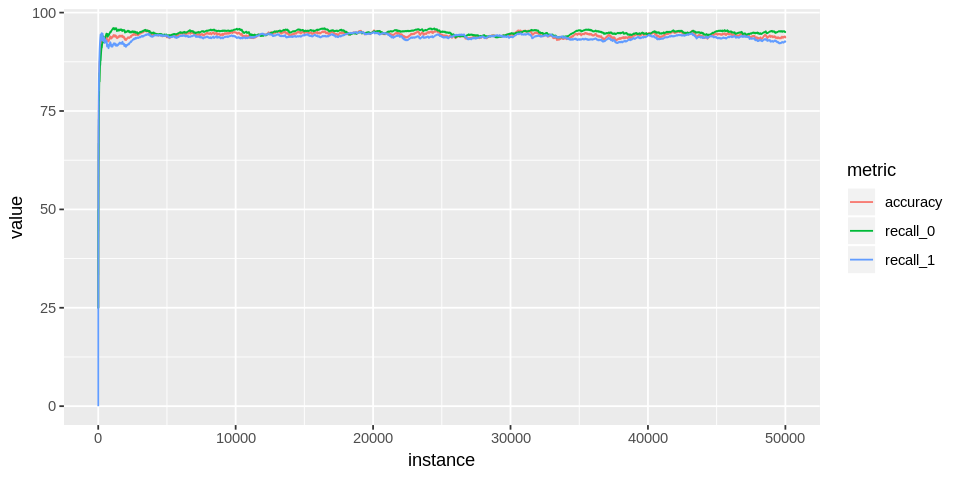

In [62]:
plot_metrics_evolution("../data/evaluation/naive_bayes/no_drift_balanced.csv")

$P(y|X) = P(X|y)P(y)$

## Mudança na verossimilhança

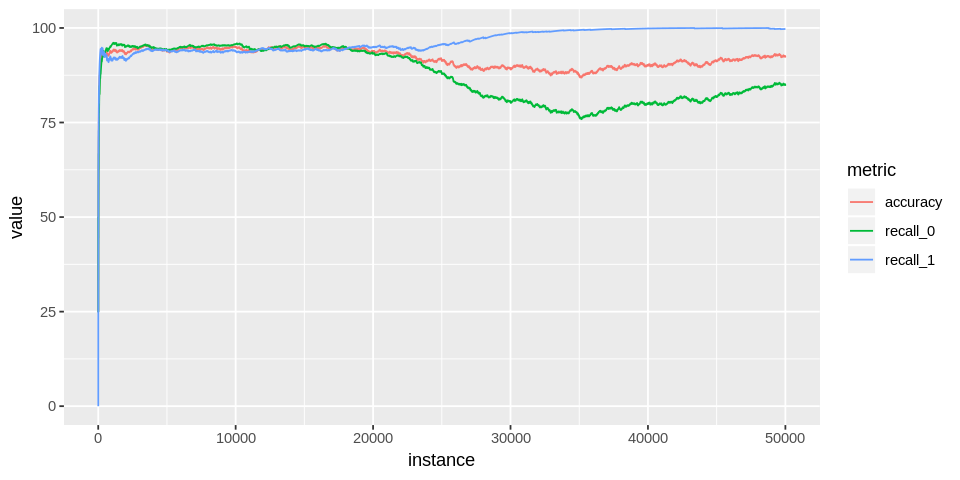

In [63]:
plot_metrics_evolution("../data/evaluation/naive_bayes/maximum_likelihood_drift.csv")

$P(y|X) = \underline{P(X|y)}P(y)$

## Mudança na probabilidade a priori (balanceamento)

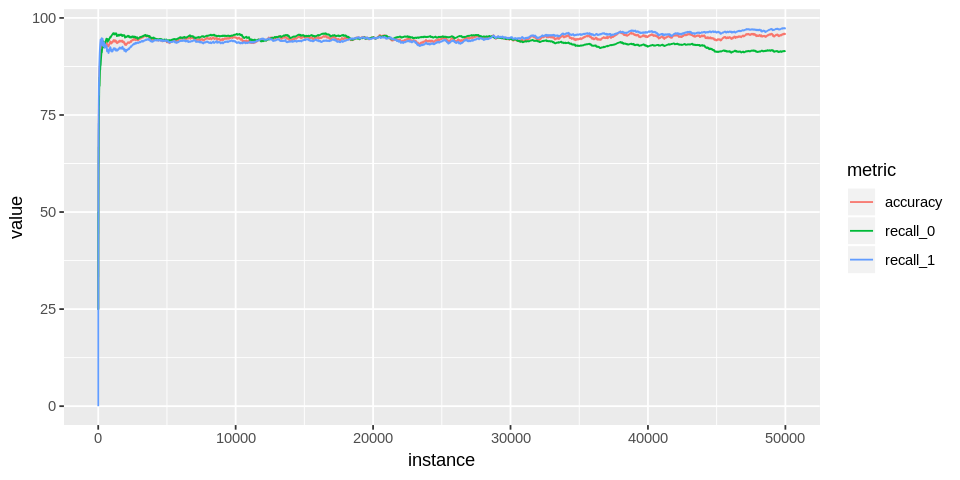

In [65]:
plot_metrics_evolution("../data/evaluation/naive_bayes/a_priori_drift.csv")

$P(y|X) = P(X|y)\underline{P(y)}$

# Objetivo
Comparar dois classificadores no cenário de fluxos de dados com a presença de mudança de conceito para auxiliar o analista a escolher qual deve ser mantido no ambiente de produção.

# Metodologia
## Descrição
* Testa e treina dois classificadores a cada novo exemplo no fluxo de dados.
 * Classificadores: Naive Bayes e OzaBagASHT.
* Calcular, **para cada classe**, uma tabela de contingência que conta os **acertos exclusivos** de cada classificador.
 * Métrica: um recall por classe, mas considerando apenas os acertos exclusivos.
 * Contagem na forma prequencial com fading factor 0,999.
* Aplicar dois testes de McNemar com base nas duas tabelas de contingência.
 * alfa: 0,05
* O classificador que vencer em mais testes é mantido em produção.

## Hipóteses
* Para cada classe:
 * $H_0: recall_1 = recall_2$
 * $H_1: recall_1 \neq recall_2$

# Resultados

# Conclusão